# Campaign Peformance Analysis #

The goal of this analysis of Campaign Performance data is to evaluate how each marketing channel has performed over the given time periods.

## Dataset Description ##

The dataset contains advertising metrics by marketing channel and week (e.g., Facebook, Google, Email, LinkedIn, Twitter). Fields include Week Start Date, Channel, Impressions, Clicks, Conversions, and Spend.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

In [2]:
data = pd.read_csv('marketing_dummy_datasets/campaign_performance_data.csv')
data.head()

,Week Start Date,Channel,Impressions,Clicks,Conversions,Spend
0,2025-01-06,Facebook,171958,2914,101,4736.63
1,2025-01-06,Google Ads,257892,1892,61,754.42
2,2025-01-06,Email,162727,1628,51,2289.80
3,2025-01-06,LinkedIn,114820,2244,194,1483.23
4,2025-01-06,Twitter,55311,1099,76,1472.45


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Week Start Date  130 non-null    object 
 1   Channel          130 non-null    object 
 2   Impressions      130 non-null    int64  
 3   Clicks           130 non-null    int64  
 4   Conversions      130 non-null    int64  
 5   Spend            130 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ KB


As we can see that there are no null values. First we normalize all the column names then convert data type of `Week Start Date` from object to datetime for monthly or seasonal trends.

In [4]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [5]:
data['week_start_date'] = pd.to_datetime(data['week_start_date'])
data['month'] = data['week_start_date'].dt.to_period('M')

In [7]:
data.describe()

,week_start_date,impressions,clicks,conversions,spend
count,130,130.000000,130.000000,130.000000,130.000000
mean,2025-04-03 12:00:00,172902.369231,2172.200000,124.246154,2613.892846
min,2025-01-06 00:00:00,52869.000000,362.000000,10.000000,201.590000
25%,2025-02-17 00:00:00,117227.500000,1171.250000,59.000000,1137.032500
50%,2025-04-03 12:00:00,169677.000000,2045.500000,99.500000,2118.650000
75%,2025-05-19 00:00:00,243332.750000,2944.750000,165.750000,3644.142500
max,2025-06-30 00:00:00,298710.000000,5416.000000,500.000000,10436.350000
std,NaN,70026.873807,1153.334205,91.546748,1919.734221


| Metric          | Observations                                                                                             |
| --------------- | -------------------------------------------------------------------------------------------------------- |
| **Impressions** | Range: 52,869 → 298,710<br>Mean: \~173k<br>→ Wide range. Possible outliers on the high end (max \~300k). |
| **Clicks**      | Range: 362 → 5,416<br>Mean: \~2,172<br>→ Large std dev (\~1,153) indicates significant variation.        |
| **Conversions** | Range: 10 → 500<br>Mean: \~124<br>→ Again, wide spread. Some weeks/channels might dominate.              |
| **Spend**       | Range: \201 → \10,436<br>Mean: \~\2,614<br>→ High spend outliers exist; budget skewed.                |

Lets check for outliers visually.

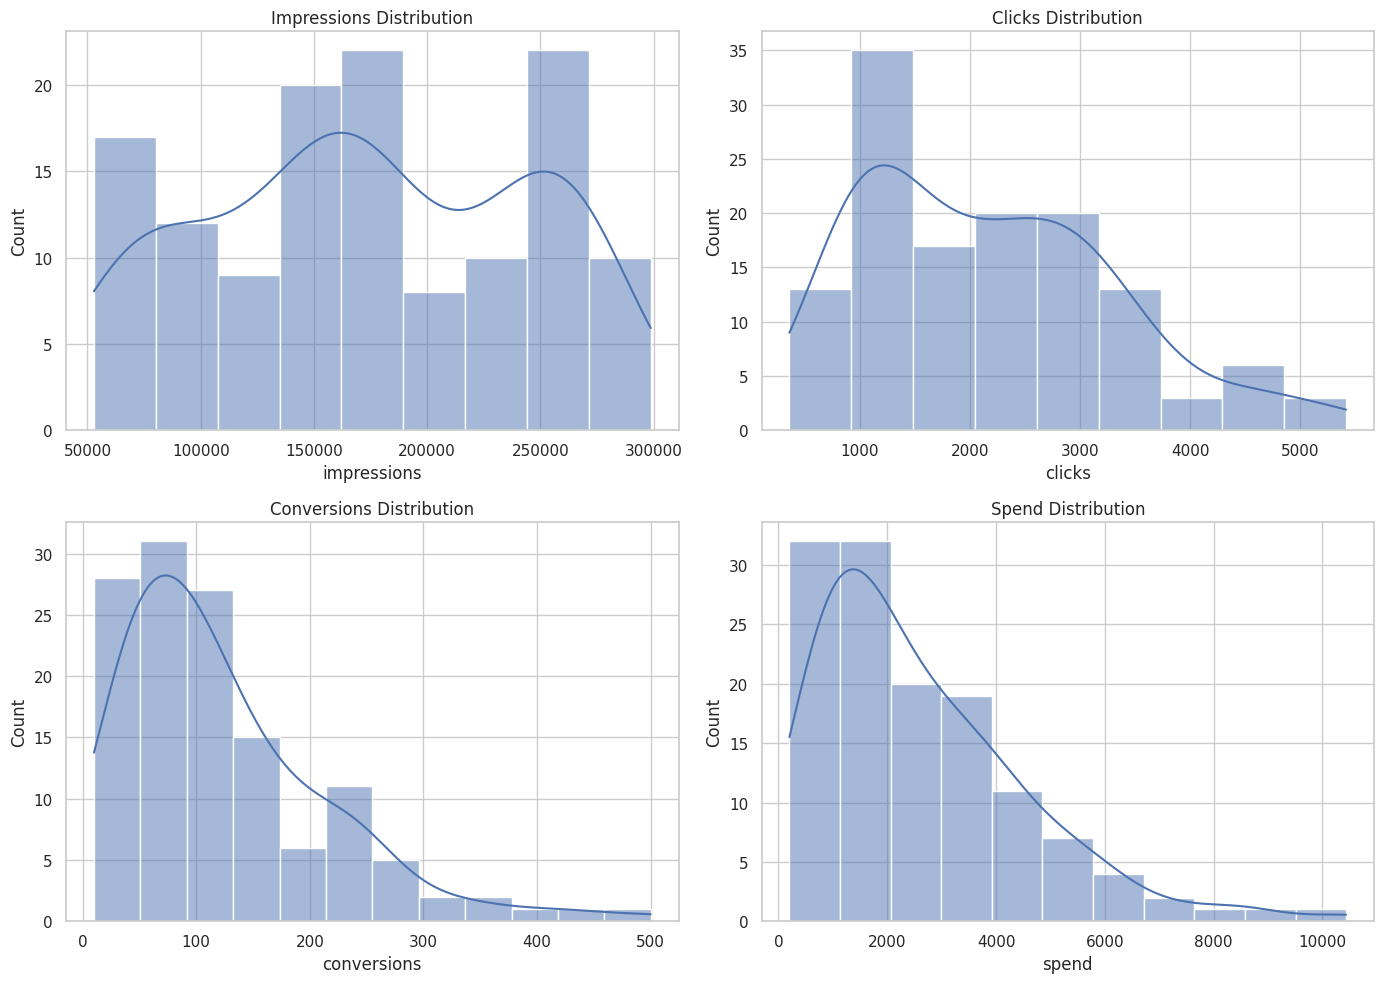

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(data['impressions'], ax=axes[0,0], kde=True)
axes[0,0].set_title('Impressions Distribution')
sns.histplot(data['clicks'], ax=axes[0,1], kde=True)
axes[0,1].set_title('Clicks Distribution')
sns.histplot(data['conversions'], ax=axes[1,0], kde=True)
axes[1,0].set_title('Conversions Distribution')
sns.histplot(data['spend'], ax=axes[1,1], kde=True)
axes[1,1].set_title('Spend Distribution')
plt.tight_layout()

### Distribution Observations

- **Impressions**: Appears multimodal or roughly uniform; does not need transformation.
- **Clicks, Conversions, Spend**: All show right-skewness, which can impact statistical modeling and machine learning. 

We will apply log transformation to normalize the distributions and stabilize variance.

In [10]:
data['clicks_log'] = np.log1p(data['clicks'])         # log1p handles 0 safely
data['conversions_log'] = np.log1p(data['conversions'])
data['spend_log'] = np.log1p(data['spend'])

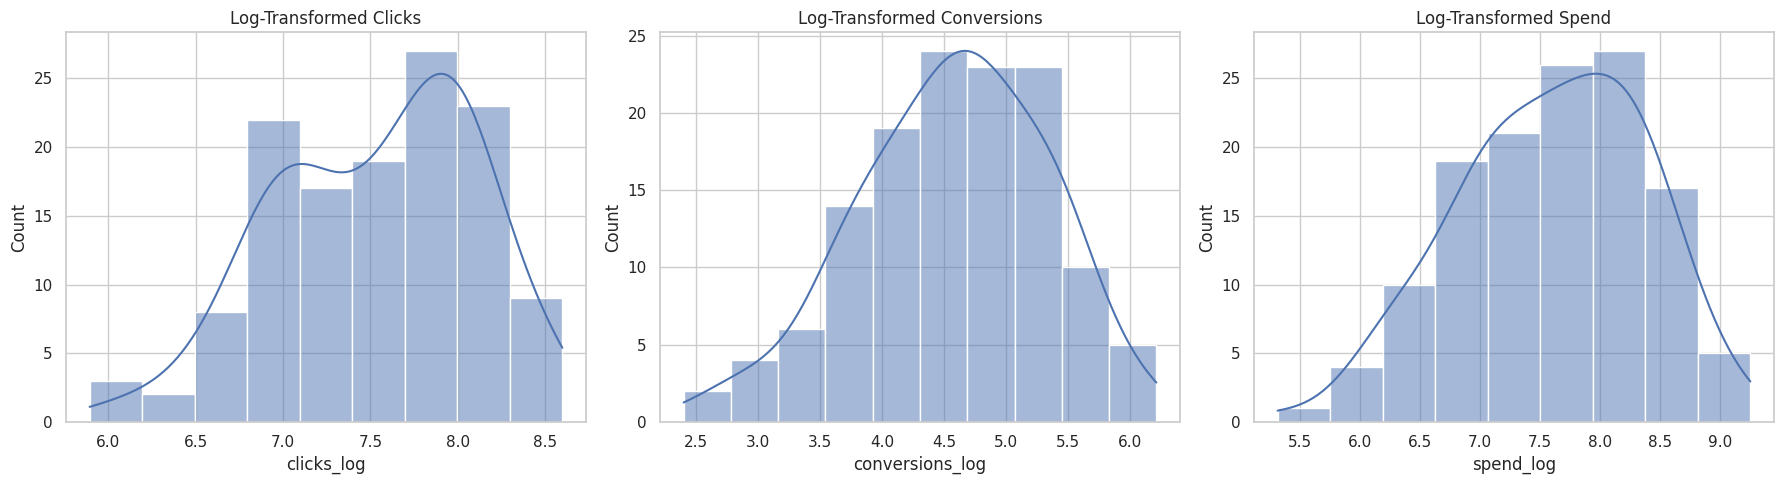

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data['clicks_log'], kde=True, ax=axs[0])
axs[0].set_title('Log-Transformed Clicks')

sns.histplot(data['conversions_log'], kde=True, ax=axs[1])
axs[1].set_title('Log-Transformed Conversions')

sns.histplot(data['spend_log'], kde=True, ax=axs[2])
axs[2].set_title('Log-Transformed Spend')

plt.tight_layout()
plt.show()


## Feature Engineering

In [13]:
## Performance Metrics
## Calculate Click-Through Rate (CTR), Conversion Rate, and Cost per Conversion
data["click_rate"] = data["clicks_log"] / data["impressions"]
data["conversion_rate"] = data["conversions_log"] / data["clicks_log"]
data["cost_per_conversion"] = data["spend_log"] / data["conversions_log"]

In [ ]:
# --- Temporal Features ---
df['month'] = df['date'].dt.to_period('M')
data['week'] = data['week_start_date'].dt.isocalendar().week
data['day_of_week'] = data['week_start_date'].dt.day_name()

## Analysis ##

### Channel-Level Performance

Evaluate how each marketing channel performed based on:

    - CTR (click-through rate)
    - Conversion Rate
    - Cost per Conversion

In [19]:
channel_summary = data.groupby("channel")[
    ["click_rate", "conversion_rate", "cost_per_conversion"]
].mean().sort_values("click_rate", ascending=False)

channel_summary.style.background_gradient(cmap="YlGnBu")

,click_rate,conversion_rate,cost_per_conversion
channel,,,
Twitter,0.000061,0.601871,1.711782
Email,0.000054,0.602602,1.669211
LinkedIn,0.000052,0.605309,1.695141
Facebook,0.000050,0.608587,1.657249
Google Ads,0.000046,0.599341,1.753980


Click-Through Rate (CTR):

    - Twitter leads with the highest CTR, suggesting high engagement per impression.
    - Google Ads trails behind, possibly due to ad fatigue or lower relevance.

Conversion Rate:
    
    - All channels hover around ~0.60, but:
        - Facebook and LinkedIn slightly outperform others in converting clicks to actions.
        - Google Ads has the lowest conversion rate, indicating weaker post-click experiences.

Cost per Conversion
    
    - Email has the lowest cost per conversion, suggesting it's the most efficient channel.
    - Google Ads again has the worst efficiency, with the highest spend per conversion.

### Monthly Trends ###
Analyze performance over time to identify seasonal patterns or campaign timing effects.

In [23]:
# Group by month
monthly_trends = data.groupby("month")[
    ["impressions", "clicks_log", "conversions_log", "spend_log"]
].sum().reset_index()

# Fix for plotting issue: convert Period to str or datetime
monthly_trends["month"] = monthly_trends["month"].astype(str)

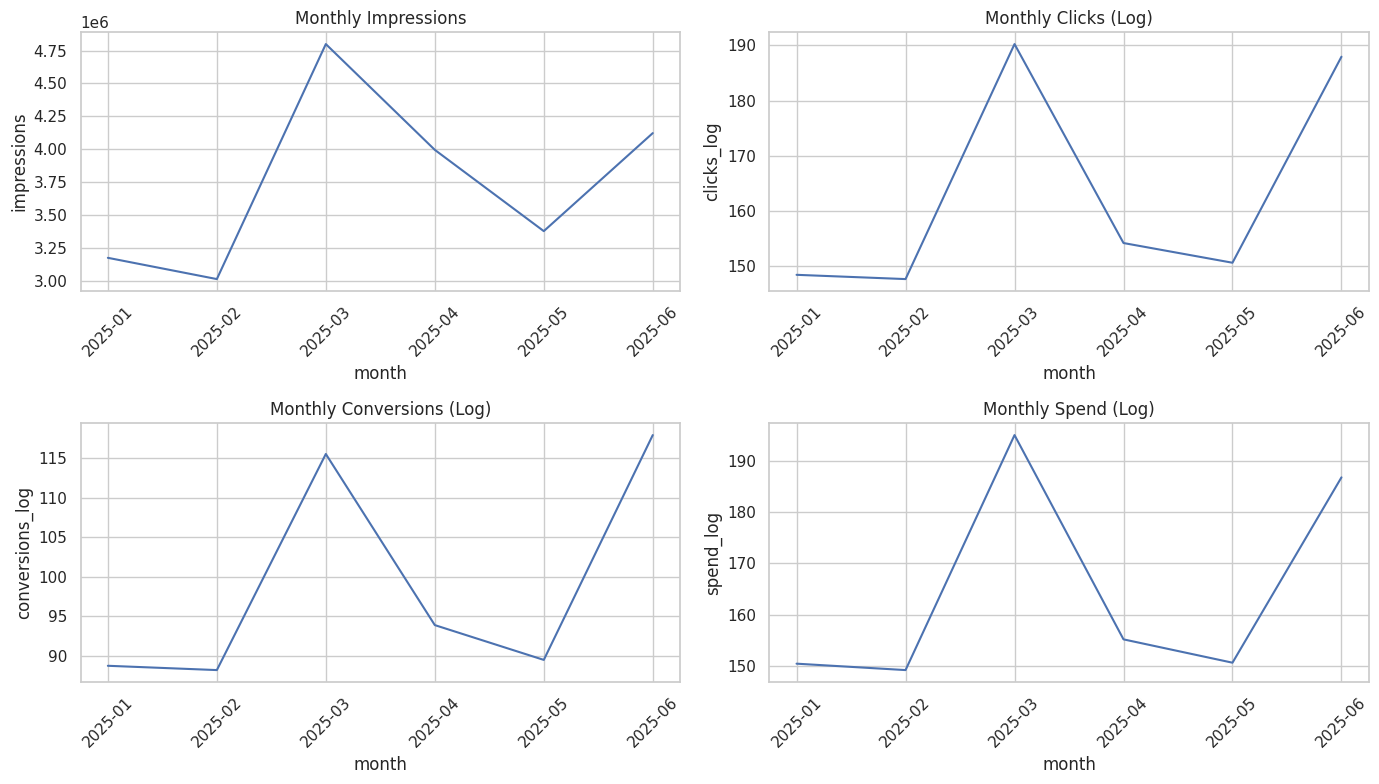

In [24]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
sns.lineplot(data=monthly_trends, x="month", y="impressions", ax=axs[0, 0])
sns.lineplot(data=monthly_trends, x="month", y="clicks_log", ax=axs[0, 1])
sns.lineplot(data=monthly_trends, x="month", y="conversions_log", ax=axs[1, 0])
sns.lineplot(data=monthly_trends, x="month", y="spend_log", ax=axs[1, 1])

axs[0, 0].set_title("Monthly Impressions")
axs[0, 1].set_title("Monthly Clicks (Log)")
axs[1, 0].set_title("Monthly Conversions (Log)")
axs[1, 1].set_title("Monthly Spend (Log)")

# Rotate x-axis labels for better readability
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

| Month       | Key Takeaway                                                                                                          |
| ----------- | --------------------------------------------------------------------------------------------------------------------- |
| **March**   | High spend, high impressions, clicks, and conversions — likely a major campaign with broad reach.                     |
| **June**    | Lower impressions than March, but **best conversion efficiency** — possibly due to better targeting or offer quality. |
| **Feb/May** | Lower across all metrics — potential off-season or underperforming campaigns.                                         |

### Spend vs Conversion Rate by Channel — With Efficiency Zones

This chart visualizes how efficiently each marketing channel converts leads into customers based on spend.

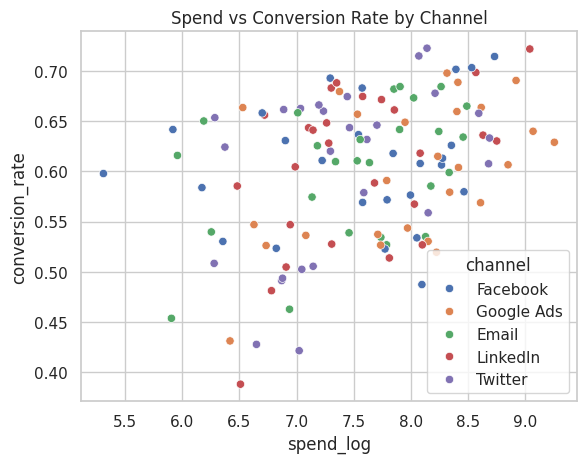

In [31]:
sns.scatterplot(data=data, x="spend_log", y="conversion_rate", hue="channel")
plt.title("Spend vs Conversion Rate by Channel")
plt.show()

Trends:

    - No strong linear correlation between spend and conversion rate—more spend ≠ better performance.
    - Channels like Twitter, LinkedIn, and Email show higher efficiency in converting users.
    - Google Ads and Facebook show potential, but may be less cost-effective without fine-tuning.

Suggestions:

    - Optimize budget allocation toward high-efficiency channels: Twitter, LinkedIn, and Email.
    - Reassess Facebook & Google Ads campaigns—analyze segments, creatives, and targeting strategies.
    - A/B test ad creatives or targeting options for underperforming high-spend campaigns.

Lets check this for individual companies.

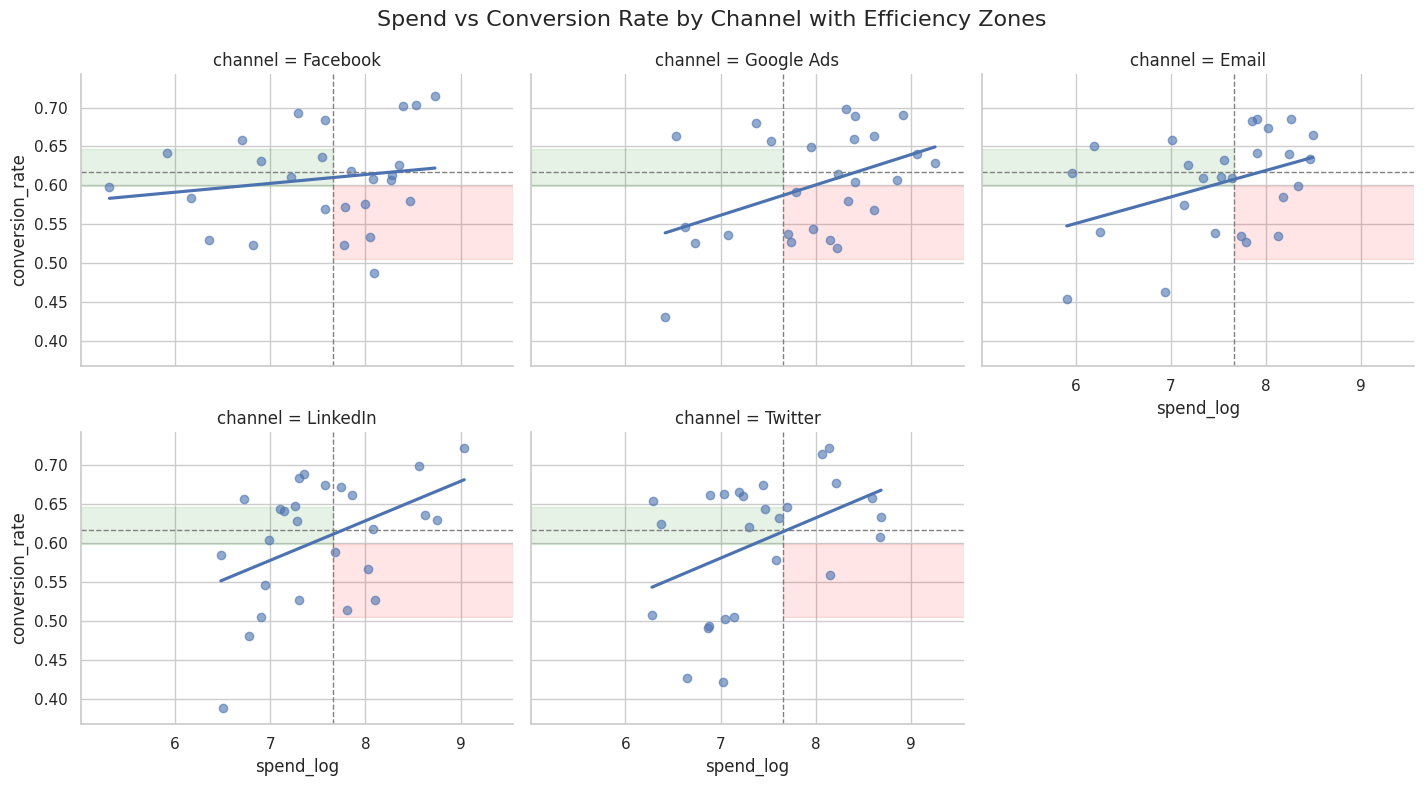

In [36]:
# Calculate global medians
spend_median = data["spend_log"].median()
conversion_median = data["conversion_rate"].median()

 # X/Y limits from actual data (for tight bounding)
spend_min = data["spend_log"].min()
spend_max = data["spend_log"].max()
conv_min = data["conversion_rate"].min()
conv_max = data["conversion_rate"].max()

# Set up FacetGrid
g = sns.FacetGrid(data, col="channel", col_wrap=3, height=4, aspect=1.2)

# Define plot function with shaded zones
def plot_with_zones(data, color, **kwargs):
    ax = plt.gca()
    
    # Expand just a little for breathing room
    ax.set_xlim(spend_min - 0.3, spend_max + 0.3)
    ax.set_ylim(conv_min - 0.02, conv_max + 0.02)

    
    # Shaded quadrants
    ax.axvspan(xmin=ax.get_xlim()[0], xmax=spend_median, ymin=conversion_median, ymax=ax.get_ylim()[1], color='green', alpha=0.1)
    ax.axvspan(xmin=spend_median, xmax=ax.get_xlim()[1], ymin=ax.get_ylim()[0], ymax=conversion_median, color='red', alpha=0.1)
    
    # Median lines
    ax.axvline(spend_median, color='gray', linestyle='--', linewidth=1)
    ax.axhline(conversion_median, color='gray', linestyle='--', linewidth=1)

    # Scatter + trend
    sns.regplot(data=data, x="spend_log", y="conversion_rate", scatter=True, ci=None, line_kws={"color": color}, scatter_kws={"alpha": 0.6}, ax=ax)

# Map plotting function to grid
g.map_dataframe(plot_with_zones)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Spend vs Conversion Rate by Channel with Efficiency Zones", fontsize=16)
plt.show()


This analysis maps out the efficiency of our spend across channels. The green zone represents ideal performance — high conversion for low spend. Red indicates inefficiencies. With this, we can double down on what works (like Email), cautiously scale what shows promise (Google Ads), and reevaluate underperformers (Twitter/LinkedIn) to optimize ROI.

Key Insights by Channel:

#### Facebook

    - Slight positive correlation between spend and conversion.
    - Campaigns mostly near the median — underutilized efficiency potential.
    - A few efficient (green zone) campaigns, but not dominant.

#### Google Ads

    - Clear positive correlation — higher spend improves conversion rate.
    - Red zone shows some inefficiencies at high spend.
    - Scaling possible but should be monitored for diminishing returns.

#### Email

    - Tight clustering of data points.
    - Many campaigns in the green zone — highly efficient.
    - Recommended to continue or slightly increase spend.

#### LinkedIn

    - Strong positive trend, but many points fall in the red zone.
    - May become inefficient at higher spend.
    - Use for targeted campaigns rather than scale.

#### Twitter

    - Moderate positive trend but wide spread in performance.
    - Appears inconsistent — both efficient and inefficient campaigns.
    - Needs improved targeting to reduce spend wastage.


### Strategic Recommendations:

| Channel       | Recommendation |
|---------------|----------------|
| **Email**     | Highly efficient — scale investment gradually. |
| **Google Ads**| Effective at scale — monitor ROI to prevent inefficiency. |
| **Facebook**  | Explore optimization strategies — potential for improvement. |
| **LinkedIn**  | Limit budget — invest in high-intent segments only. |
| **Twitter**   | Refine audience targeting to improve consistency. |

## Conclusion

This analysis provided a data-driven view of how spend influences conversion rates across key marketing channels.

### Key Takeaways:
- **Email** is the most efficient channel with consistently high conversion and low spend — a prime candidate for further scaling.
- **Google Ads** shows a strong return on higher spend, but requires monitoring for diminishing returns beyond a certain threshold.
- **Facebook** has stable performance but underutilized efficiency. There's room to optimize without increasing budget drastically.
- **LinkedIn** and **Twitter** exhibit lower efficiency at higher spend levels — suggesting a need for audience refinement or budget reallocation.

### Strategic Action:
We should adopt a **channel-specific spend strategy**:
- **Scale** proven efficient channels (Email, Google Ads).
- **Optimize** and experiment with mid-performance channels (Facebook).
- **Reduce or redirect** spend from underperforming zones (LinkedIn, Twitter) unless new targeting strategies are tested.

> This approach ensures we're maximizing marketing ROI by aligning spend with conversion efficiency across channels.
